# TACCO overview

This example uses synthetic data to illustrate the TACCO annotate workflow and some downstream analysis and visualization tools following Figure 1 from: 

(Mages et. al.): Mages, S., Moriel, N., Avraham-Davidi, I. et al. TACCO unifies annotation transfer and decomposition of cell identities for single-cell and spatial omics. Nat Biotechnol (2023). https://doi.org/10.1038/s41587-023-01657-3

In [1]:
import tacco as tc
import os
import sys

# The notebook expects to be executed either in the workflow directory or in the repository root folder...
sys.path.insert(1, os.path.abspath('workflow/overview' if os.path.exists('workflow/overview/visualization_helper.py') else '.')) 
import visualization_helper

## Load data

In [2]:
visualization_helper.generate_data()
visualization_helper.initialize_plotting_params()
adata = visualization_helper.generate_adata()
colors_celltype = ['#0f0','#f00','#00f',]

## TACCO: a flexible framework for the annotation and analysis of cells and cell-like objects
TACCO aims to annotate single cells and cell-like objects like Slide-seq beads (objects *b*) or Visium spots, with compositional annotations. In cases with discrete ground truth (e.g. a B cell vs a fibroblast) we interpret the compositional annotation as probabilities of belonging to a category *t*. Both objects *b* and categories *t* are in a common high dimensional data space, e.g., expression space. Generally, objects that are close to a category in that space, should have a high contribution of that category in the compositional annotation.

TACCO generates annotations for new datasets of mixtures using an annotated single-cell reference. The result is a compositional annotation for the new datapoints.
The framework is completed by a set of downstream analysis tools, some of which are especially optimized for analysis involving compositional annotations. TACCO relies on Anndata and seamlessly integrates with the Scanpy ecosystem.

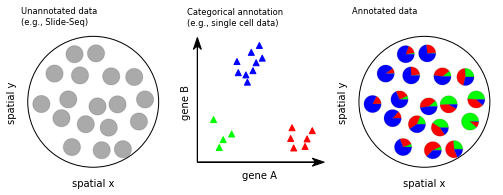

In [3]:
fig, axs = tc.pl.subplots(3, axsize=(2,2))
visualization_helper.plot_unannotated_data(axs[0][0], adata)
visualization_helper.plot_scRef(axs[0][1])
visualization_helper.plot_annotated_data(axs[0][2], adata)

## Compositional Annotations

Illustrative embeddings of cells and cell-like objects annotated (left) for mixtures (pie charts) of idealized pure contributions (large triangles); (middle) as ambiguous annotations (triangles with colored borders) for technical artifacts like high ambient contributions or dropout levels; and (right) continuous annotations (circles) along biological continua.

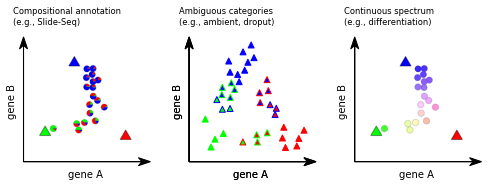

In [4]:
fig, axs = tc.pl.subplots(3, axsize=(2,2), sharex=True, sharey=True)
visualization_helper.plot_compositional_annotation(axs[0][0])
visualization_helper.plot_ambiguous_categories(axs[0][1])
visualization_helper.plot_continuous_spectrum(axs[0][2])

## Annotation process:
Far left: A labeled reference dataset (e.g., scRNA-seq data, colored triangles) and a new dataset (e.g. Slide-seq beads, circles) is first presented in a common high-dimensional space (e.g., expression space) optionally using platform normalization to make the datasets comparable.<br> 
Near left: TACCO represents the reference categories by one or multiple representative profiles (large colored triangles).<br>
Near right: TACCO uses semi-unbalanced entropic optimal transport to transfer annotations from the reference categories to the new dataset (arrows), generating compositional annotations for the new datapoints (colored piecharts). To improve the capture of the subdominant contributions, this process is iterated.<br>
Far right: TACCO provides as output compositional annotations for the new dataset.

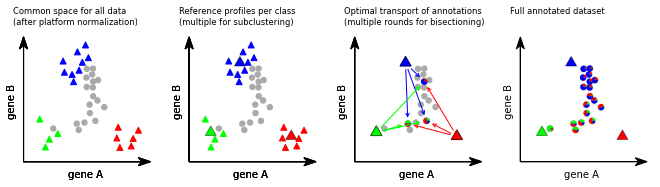

In [5]:
fig, axs = tc.pl.subplots(4, axsize=(2,2), sharex=True, sharey=True)
visualization_helper.plot_common_space(axs[0][0])
visualization_helper.plot_reference_profiles(axs[0][1])
visualization_helper.plot_optimal_transport(axs[0][2])
visualization_helper.plot_full_annotated(axs[0][3])

## Analysis tools for compositional annotations, especially for spatial data
TACCO comes with a set of tools to quantify spatial relationships on long (tissue) and short (cellular neighbourships) length scales and can infer spatial regions. 

To score co-localization or co-occurrence of annotations, TACCO calculates the probability to find an *annotation* at a distance *x* from a center annotation *center* normalized by the probability to find *annotation* regardless of a *center*:

$$ \frac{p(annotation|center,x)}{p(annotation)} $$

This is well-defined also for non-categorical annotations, which are commonplace for the compositional annotations created with TACCO and for pairs of unrelated annotations.

co_occurrence: The argument `distance_key` is `None`, meaning that the distance which is now calculated on the fly will not be saved. Providing a precalculated distance saves time in multiple calls to this function.
calculating distance for sample 1/1


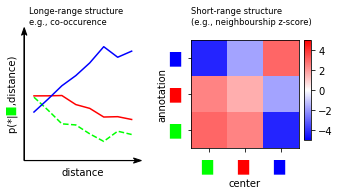

In [6]:
tc.tl.co_occurrence(adata, 'fractions', result_key='fractions', delta_distance=0.5, sparse=False, n_permutation=10)
fig, axs = tc.pl.subplots(2, axsize=(1.5,1.5),  wspace=0.5)
tc.pl.co_occurrence(adata, 'fractions', score_key='composition', show_only_center=['f0'], colors={f'f{i}': colors_celltype[i] for i in range(len(colors_celltype))}, legend=False, axsize=(1.5,1.5), ax=axs[0][0]);
visualization_helper.set_pl_co_occ_params(axs[0][0], adata)
tc.pl.co_occurrence_matrix(adata, 'fractions', score_key='z', axsize=(1.2,1.2), restrict_intervals=[0], cmap_vmin_vmax=[-5,5], ax=axs[0][1], scale_legend=0.5)
visualization_helper.set_pl_co_occ_matrix(axs[0][1])

## Object splitting
For each observation in the unannotated dataset the annotation method generates an assignment of a composition of annotation categories. <br>
Generally, each observation is associated with more than one category with non-zero contribution. When the categories are cell types, this can be problematic for downstream applications that require the expression profiles of single cells as input, i.e. pure profiles that can be attributed to a single cell. For example, as cell-type-related expression constitutes a strong signal, analysis of expression programs is easier across cells of a shared type. Thus, it is desirable to derive several "virtual" observations for every real observation, which correspond to the pure contribution of each annotation category. <br>

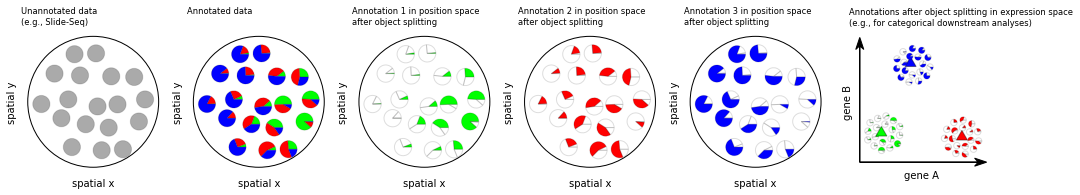

In [7]:
tc.tl.find_regions(adata, annotation_key='fractions', resolution=1.5, position_weight=0.5)
fig, axs = tc.pl.subplots(6, axsize=(2,2))
visualization_helper.plot_unannotated_data(axs[0][0], adata)
visualization_helper.plot_annotated_data(axs[0][1], adata)
visualization_helper.plot_object_split_green(axs[0][2], adata)
visualization_helper.plot_object_split_red(axs[0][3], adata)
visualization_helper.plot_object_split_blue(axs[0][4], adata)
visualization_helper.plot_object_splitting(axs[0][5])

## Enrichment of compositional annotations

TACCO supports various approaches to visualize compositional differences in the spatial structure of a sample and estimate the statistical significance of these differences / enrichments. In particular, TACCO uses sample information to calculate enrichments not across observations (single cells / spatial beads, which are no independent observations and can lead to p-value inflation), but across multiple samples, which gives meaningful and reasonable p-values.

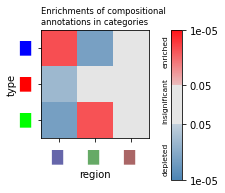

In [8]:
fig, ax = tc.pl.subplots(n_x=1, axsize=(1.5,1.5))
tc.pl.significances(tc.tl.enrichments(adata, 'fractions', 'region', ), 'p_mwu_fdr_bh', 'fractions', 'region', annotate_pvalues=False, ax=ax[0][0], scale_legend=0.75);  
visualization_helper.set_pl_significances_params(fig)

## Inferring Regions
For spatially-convoluted expression data, such as in spatial transcriptomics methods including Slide-seq and Visium, clustering (of beads or spots) in expression space is less meaningful as individual cells are mixed. “Regions” which are defined both in position and expression or annotation space can be a meaningful alternative. TACCO implements a method to define such regions consisting of two steps:
1. Construction of one k-nearest neighbors graph based on expression (or annotation) distances and another k-nearest neighbors graph based on physical distances
2. Combination of the two graphs as a weighted sum of the graphs’ adjacencies

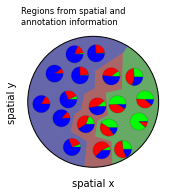

In [9]:
fig, axs = tc.pl.subplots(axsize=(2,2))
visualization_helper.plot_region_voronoi(axs[0][0], adata)